In [3]:
import codecs
import os
import sys
import pandas as pd
import numpy as np
from tensorflow.keras.metrics import Metric
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from keras import Input, Model, losses, Sequential
from keras.callbacks import Callback
from keras.layers import Lambda, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras_bert import Tokenizer, load_trained_model_from_checkpoint
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle
import random
#from keras_bert import get_base_dict, get_model, compile_model, gen_batch_inputs
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import recall_score, precision_score, f1_score

In [4]:
config_path = './chinese_L-12_H-768_A-12/bert_config.json'
checkpoint_path = './chinese_L-12_H-768_A-12/bert_model.ckpt'
dict_path = './chinese_L-12_H-768_A-12/vocab.txt'
text_loc = "C:\\Users\\pppoe\Desktop\\深度學習embedding\\BertModel\\text_labeled\\"
split_text_dir = Path("D:\\論文相關\\data\\text_loc\\split_text\\new_splited")
maxlen = 100


In [325]:
for categorie in emotion_dict.keys():
    cur_cat = emotion_dict[categorie]
    if "正面" in categorie:
        pnt = 1
    elif "負面" in categorie:
        pnt = -1
    for key in cur_cat.keys():
        emotion_dict[categorie][key] = pnt

In [326]:
emotion_dict

{'年報負面': {'矮小': -1,
  '安於現狀': -1,
  '暗藏': -1,
  '暗淡': -1,
  '暗黑': -1,
  '暗流': -1,
  '暗箱操作': -1,
  '黯淡': -1,
  '扒皮': -1,
  '把持': -1,
  '罷免': -1,
  '霸道': -1,
  '霸權': -1,
  '霸佔': -1,
  '擺佈': -1,
  '擺設': -1,
  '敗訴': -1,
  '絆腳石': -1,
  '綁架': -1,
  '包袱': -1,
  '薄弱': -1,
  '飽和': -1,
  '保護傘': -1,
  '保守': -1,
  '報廢': -1,
  '報復': -1,
  '抱怨': -1,
  '暴跌': -1,
  '暴發': -1,
  '暴力': -1,
  '暴利': -1,
  '暴露': -1,
  '暴亂': -1,
  '爆倉': -1,
  '悲觀': -1,
  '悲傷': -1,
  '悲痛': -1,
  '背道而馳': -1,
  '背離': -1,
  '被動': -1,
  '被控': -1,
  '被迫': -1,
  '被取消': -1,
  '被淘汰': -1,
  '笨重': -1,
  '崩潰': -1,
  '崩盤': -1,
  '逼迫': -1,
  '閉門造車': -1,
  '閉塞': -1,
  '弊病': -1,
  '弊端': -1,
  '壁壘': -1,
  '邊緣化': -1,
  '編造': -1,
  '貶低': -1,
  '貶損': -1,
  '貶值': -1,
  '變差': -1,
  '變壞': -1,
  '變節': -1,
  '變臉': -1,
  '變賣': -1,
  '變態': -1,
  '變天': -1,
  '變相': -1,
  '變質': -1,
  '瀕臨': -1,
  '冰冷': -1,
  '病毒': -1,
  '病害': -1,
  '病魔': -1,
  '病弱': -1,
  '病態': -1,
  '病疫': -1,
  '波動': -1,
  '波及': -1,
  '波折': -1,
  '剝奪': -1,
  '剝離': -1,
  '駁回': -1,
  '搏殺':

In [73]:
text_pd_with_middle = pd.read_pickle("text_all_bigger_than_0_with_middle.pickle")
text_pd_without_middle = pd.read_pickle("text_all_bigger_than_0_without_middle.pickle")
emotion_dict = pd.read_pickle("New_emotion_dict.pickle")
all_text =pd.read_pickle("text_all_bigger_than_0_with_middle.pickle")


In [346]:
all_text['2020-04-20']

{'Frida': ['謝謝股癌大推薦小菜雞剛買這本', '謝謝'],
 'jay liu': ['要買之前可以先聽一下說書',
  '裡面有講大綱跟心得',
  '書真的很硬有一堆看不懂的比喻',
  '他的策略就是把本金放到風險低的投資用來比較激進的投資',
  '他本人是推當選擇權買方賭遇到黑天鵝',
  '不過選擇權不太適合新手歐尤其是千萬不要當選擇權賣方',
  '現買現虧',
  '當莊家真好真的有一些人很好騙',
  '好想當莊家開一個原油正',
  '建議不要買權證比選擇權還危險'],
 'Halladay Chu': ['我也來推薦一本書好了如果對於股災的歷史有興趣的人可以看投資金律',
  '他介紹了很多股災事件有點像在看故事',
  '的書我看了好幾本最推薦共同基金必勝法則上下冊內容很多但是看完真的會對這個流派了解很多新手建議先看過綠角的入門書有個大概了解再來啃這套'],
 'KIN L': ['選擇權賠過四億的公司財務路過揮手',
  '就是前幾年事件那個我們算是很小咖死的人滿多的',
  '聽說還有人在跟進不過我覺得跟最近被追繳錢商業用途一樣合約的確有寫但是通常簽單都是來了說大概賺多少賠多少就給大家簽了大家大概看一遍確認吃到飽就簽了怎知道有些項目深藏陷阱字很小還是英文條例居多公式也很複雜人家一句話說你自己沒看清楚的說的也沒錯也就認了沒轍以後就知道不懂的千萬不要碰',
  '小時版',
  '定期定額聽銀行的買基金從來沒賺到錢',
  '其他就不知道了'],
 '史提夫': ['四億', '是避險嗎', '喔喔'],
 '台中川大志': ['自覺贏不了大盤就是走約翰柏格流派了不過多大數的人就是愛賭', '不如直接做期貨'],
 'MK H': ['資產配置的穩定對於高收人士滿不錯的',
  '但錢不多的是不會甘願一年這樣的也沒啥不對你要選股就要多做功課',
  '綠角的東西不錯只是我覺得她把他的方法捧高去說其他人方法是錯的這有待商榷',
  '參見文人相輕那集你要當公務員求穩定不代表創業的人就是比你笨'],
 'Felix Lo': ['各有需要承擔的風險但人性就跟羊群效應一樣賺的幸福感比不過賠的恐懼'],
 '小X她男友': ['請問大家怎麼看元大原油正'],
 'ジャク ユ': ['不戴眼鏡看像戴了眼鏡像'],
 None: ['股癌已經

In [347]:
dict_emotion_len0 = {"pos":[], "neg":[], "neu":[]}
for date in splited_text_pd_with_middle:
    cur_date_text = splited_text_pd_with_middle[date]
    
    for sentence in cur_date_text:
        if_found = False
        sentence_pnt = 0
        for word in sentence:
            for page in emotion_dict.keys():
                cur_minor_dict = emotion_dict[page]

                if cur_minor_dict.get(word):
                    #print(word)
                    sentence_pnt+=cur_minor_dict.get(word)
                    #print(page,word, cur_minor_dict.get(word))
                    if_found = True
        temp_sentence = "".join(sentence)
        #print(temp_sentence)
        if if_found:
            
            #print(temp_sentence)
            if sentence_pnt> 0:
                dict_emotion_len0["pos"].append((date, temp_sentence, 1))
            elif sentence_pnt< 0:
                dict_emotion_len0["neg"].append((date, temp_sentence, -1))
            else:
                dict_emotion_len0["neu"].append((date, temp_sentence, 0))
        else:
            dict_emotion_len0["neu"].append((date, temp_sentence, 0))

#all_text_counted.append((pos, neg, neu))
#print(len(all_text_counted))
#with open(text_loc+f"{file_name[:-7]}_labeled.pickle", "wb") as f:
    #pickle.dump(all_text_counted, f)

In [354]:
#dict_emotion_len0 = pd.DataFrame(dict_emotion_len0).T
columns = ["date", "text", "label"]
all_text_len0_neu = pd.DataFrame(dict_emotion_len0["neu"])
all_text_len0_neu.columns = columns
all_text_len0_pos = pd.DataFrame(dict_emotion_len0["pos"])
all_text_len0_pos.columns = columns
all_text_len0_neg = pd.DataFrame(dict_emotion_len0["neg"])
all_text_len0_neg.columns = columns

In [355]:
all_text_len0_neg

,date,text,label
0,2020-03-07,問一個新手問題這是哪個看盤啊我的都是昨收,-1
1,2020-03-09,不行的樣子剛才爬文看到說可以用機器人刪我試試,-1
2,2020-03-10,小道瓊跌停見證歷史,-1
3,2020-03-10,往好的方面想很多人在抱怨的股價太貴這個問題終於被解決了,-1
4,2020-03-11,台股強呀想說美股跌那麼多會跟跌,-1
...,...,...,...
146146,2021-12-28,瑞莎想一個人挑戰各地方體邪真的太難了拉,-1
146147,2021-12-28,發哥要挑戰摸頂惹,-1
146148,2021-12-28,是我拖累你們,-1
146149,2021-12-28,忘記被支配的恐懼了嗎,-1


In [361]:
all_text_len0_pos[all_text_len0_pos["date"] == "2020-04-21"].shape

(69, 3)

In [362]:
all_text_len0_neg[all_text_len0_neg["date"] == "2020-04-21"].shape

(31, 3)

In [364]:
set(all_text_len0_pos["date"].values)

{'2020-03-07',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-29',
 '2020-03-30',
 '2020-03-31',
 '2020-04-01',
 '2020-04-02',
 '2020-04-03',
 '2020-04-04',
 '2020-04-05',
 '2020-04-06',
 '2020-04-07',
 '2020-04-08',
 '2020-04-09',
 '2020-04-10',
 '2020-04-11',
 '2020-04-12',
 '2020-04-13',
 '2020-04-14',
 '2020-04-15',
 '2020-04-16',
 '2020-04-17',
 '2020-04-18',
 '2020-04-19',
 '2020-04-20',
 '2020-04-21',
 '2020-04-22',
 '2020-04-23',
 '2020-04-24',
 '2020-04-25',
 '2020-04-26',
 '2020-04-27',
 '2020-04-28',
 '2020-04-29',
 '2020-04-30',
 '2020-05-01',
 '2020-05-02',
 '2020-05-03',
 '2020-05-04',
 '2020-05-05',
 '2020-05-06',
 '2020-05-07',
 '2020-05-08',
 '2020-05-09',
 '2020-05-10',
 '2020-05-11',
 '2020-05-12',
 '2020-05-13',
 '2020-05-14',
 '2020-05-

In [365]:
dict_emotion_len0 ={}
for date in set(all_text_len0_pos["date"].values):
    cur_date_pos = all_text_len0_pos[all_text_len0_pos["date"] == date].shape[0]
    cur_date_neg = all_text_len0_neg[all_text_len0_neg["date"] == date].shape[0]
    print(cur_date_pos, cur_date_neg)
    dict_emotion_len0[date] =  {"pos":cur_date_pos, "neg":cur_date_neg}
dict_emotion_len0 = pd.DataFrame(dict_emotion_len0).T
dict_emotion_len0


171 98
256 68
3 0
2 3
259 99
411 137
214 65
120 42
91 28
12 5
582 184
258 85
1236 660
292 120
20 11
104 37
820 334
358 134
245 96
190 54
824 465
69 31
1415 736
67 29
276 118
209 99
484 190
129 50
159 68
4 0
436 143
1213 725
643 490
461 226
91 33
480 162
556 303
1707 926
400 241
396 183
351 128
157 56
571 188
477 214
615 300
614 192
75 17
522 260
296 116
204 74
5 5
329 165
851 462
937 457
338 141
725 311
1085 554
248 89
5 1
767 264
852 539
122 37
1080 508
351 123
674 408
101 37
230 93
205 80
40 15
110 40
676 412
666 294
249 95
45 22
270 94
759 476
232 94
369 126
3 1
409 149
285 162
1626 969
298 194
375 134
849 346
565 216
294 102
78 32
1022 462
680 383
1117 104
256 84
376 158
1115 492
169 64
149 47
978 358
174 60
861 440
161 74
324 100
973 461
564 248
765 409
650 253
232 101
682 337
812 417
298 111
703 394
723 291
5 6
253 66
279 72
296 90
174 43
226 101
101 32
2 3
384 189
265 144
304 119
196 103
242 125
521 326
123 43
2 1
310 99
684 288
126 53
298 43
1250 653
488 210
186 63
216 75
377 1

,pos,neg
2020-10-27,171,98
2020-10-23,256,68
2020-04-13,3,0
2020-04-11,2,3
2020-06-05,259,99
...,...,...
2021-12-09,888,407
2020-03-27,5,4
2021-08-01,1796,553
2021-04-01,494,211


In [381]:
dict_emotion_len0 = dict_emotion_len0.sort_index()
dict_emotion_len0.to_pickle(f"D:\\論文相關\\data\\emotion_data\\dict_emotions_len_0_training_data.pkl")

In [370]:
dict_emotion_list = []
for length in range(3, 7):
    dict_emotion ={}
    for date in set(all_text_len0_pos["date"].values):
        cur_date_pos = all_text_len0_pos[(all_text_len0_pos["date"] == date) & (all_text_len0_pos["text"].str.len()>=length)].shape[0]
        cur_date_neg = all_text_len0_neg[(all_text_len0_neg["date"] == date )& (all_text_len0_neg["text"].str.len()>=length)].shape[0]
        print(cur_date_pos, cur_date_neg)
        dict_emotion[date] =  {"pos":cur_date_pos, "neg":cur_date_neg}
        
    dict_emotion = pd.DataFrame(dict_emotion).T
    dict_emotion["pos_ratio"] = dict_emotion["pos"]/ (dict_emotion["pos"]+dict_emotion["neg"])
    dict_emotion["neg_ratio"] = dict_emotion["neg"]/ (dict_emotion["pos"]+dict_emotion["neg"])
    dict_emotion = dict_emotion.sort_index()
    dict_emotion_list.append(dict_emotion)

168 97
248 67
3 0
2 3
249 99
404 137
211 65
119 42
88 28
11 5
571 184
249 83
1202 647
283 118
19 11
102 37
801 329
353 132
242 96
185 54
811 460
67 30
1368 729
66 29
267 118
206 98
467 188
128 50
158 68
3 0
427 142
1193 720
628 484
432 223
89 33
468 160
543 299
1680 915
394 240
386 181
348 127
151 54
553 185
467 214
603 297
592 189
74 16
511 259
294 115
200 73
5 5
324 162
827 458
912 452
333 139
699 308
1059 548
244 89
5 1
748 259
832 534
121 37
1059 502
341 122
657 402
100 37
223 93
199 78
37 15
105 40
660 404
647 291
246 95
43 22
266 93
738 471
232 93
361 125
3 1
401 148
282 160
1557 948
293 192
371 132
824 339
545 213
286 101
77 32
1016 461
670 377
1054 101
245 84
368 155
1086 482
161 64
144 47
950 354
173 60
843 440
153 71
318 99
934 445
549 246
742 405
638 252
227 100
664 330
796 410
292 111
692 387
693 291
5 6
246 65
275 71
289 88
170 43
224 101
93 32
2 3
376 189
260 144
299 119
193 100
234 125
510 325
121 43
2 1
298 95
659 281
121 53
294 43
1227 646
477 207
181 63
212 74
368 187

262 122
479 237
640 392
1304 655
293 191
1168 680
195 120
1140 546
129 50
160 63
102 48
69 31
945 435
478 271
508 266
1002 532
211 103
180 72
232 94
22 10
155 55
1099 685
101 48
323 142
1013 504
683 277
517 227
278 106
341 101
243 111
360 113
349 158
472 232
167 34
76 35
531 272
1144 584
870 478
1175 607
826 397
61 43
178 60
117 58
70 20
242 64
1004 460
3 2
320 152
1328 539
1047 499
1052 499
426 207
1531 713
14 5
263 141
143 57
626 290
898 432
510 237
381 170
568 268
97 33
202 68
282 82
174 47
832 440
192 81
857 393
701 355
377 199
2 1
1148 552
898 355
39 15
1 4
653 294
153 71
347 134
539 276
581 285
537 217
549 213
68 19
204 80
947 478
136 45
343 119
234 79
314 192
253 136
1028 521
852 414
260 76
281 154
639 475
127 61
963 601
79 30
659 297
260 84
384 111
455 231
10 10
959 415
787 378
140 54
769 374
198 58
448 168
129 34
71 36
1091 713
136 48
267 140
4 2
679 367
290 129
170 65
280 100
914 446
446 169
620 256
329 121
299 87
965 406
455 201
113 36
302 114
210 82
701 407
145 45
472 212
7

7 5
313 110
595 278
388 168
996 547
663 385
650 281
2 2
177 65
203 92
280 121
133 50
280 105
425 174
315 139
866 547
173 83
107 57
264 127
191 92
161 80
402 177
165 43
1153 580
4 1
363 134
185 54
214 99
388 229
606 288
71 15
272 124
93 35
371 182
163 70
577 226
2 1
128 69
555 264
684 295
1159 791
223 112
256 94
211 87
79 27
225 100
335 157
877 477
229 111
214 83
59 20
36 22
246 105
478 170
94 46
106 39
423 193
681 399
613 234
125 48
1112 546
421 145
2 0
216 98
160 52
420 223
183 83
112 48
125 41
147 50
871 440
217 63
829 360
872 384
584 232
542 272
19 9
8 2
415 215
290 87
308 234
825 431
240 106
898 514
723 443
274 140
3 2
391 136
228 72
595 213
558 264
120 57
358 99
376 196
574 419
444 223
360 141
21 6
285 140
1265 598
475 182
159 73
357 167
137 71
1225 828
732 408
234 78
121 33
744 413
310 140
323 156
395 224
392 119
310 86
89 24
638 298
203 84
223 79
200 66
150 54
532 248
119 44
698 377
444 267
370 183
452 187
577 239
525 345
1166 543
259 166
416 163
195 67
626 296
926 429
333 164
1

In [378]:
dict_emotion_list[3]

,pos,neg,pos_ratio,neg_ratio
2020-03-07,2,1,0.666667,0.333333
2020-03-10,3,2,0.600000,0.400000
2020-03-11,3,1,0.750000,0.250000
2020-03-12,2,1,0.666667,0.333333
2020-03-13,1,2,0.333333,0.666667
...,...,...,...,...
2021-12-24,584,232,0.715686,0.284314
2021-12-25,415,156,0.726795,0.273205
2021-12-26,310,86,0.782828,0.217172
2021-12-27,443,218,0.670197,0.329803


In [380]:
with open(f"D:\\論文相關\\data\\emotion_data\\dict_emotions_len_3-7_list.pkl", "wb") as f:
    pickle.dump(dict_emotion_list, f)

In [83]:
splited_text_pd_with_middle = pd.read_pickle(str(split_text_dir)+"\\split_text_all_bigger_than_0_with_middle.pickle")
splited_text_pd_with_middle['2020-03-07']

[['群組數', '即將', '超越', '朋友', '數'],
 ['有', '人', '要', '掛單', '嗎'],
 ['好像', '有一點', '反彈'],
 ['千', '點', '殺'],
 ['包', '著', '尿布', '怒', '掛單'],
 ['美股', '殺', '得', '好'],
 ['問',
  '一',
  '個',
  '新手',
  '問題',
  '這',
  '是',
  '哪',
  '個',
  '看盤',
  '啊',
  '我',
  '的',
  '都',
  '是',
  '昨',
  '收'],
 ['一般', '的', '交易', '軟體']]

In [6]:
emotion_dict

{'年報負面': {'矮小': True,
  '安於現狀': True,
  '暗藏': True,
  '暗淡': True,
  '暗黑': True,
  '暗流': True,
  '暗箱操作': True,
  '黯淡': True,
  '扒皮': True,
  '把持': True,
  '罷免': True,
  '霸道': True,
  '霸權': True,
  '霸佔': True,
  '擺佈': True,
  '擺設': True,
  '敗訴': True,
  '絆腳石': True,
  '綁架': True,
  '包袱': True,
  '薄弱': True,
  '飽和': True,
  '保護傘': True,
  '保守': True,
  '報廢': True,
  '報復': True,
  '抱怨': True,
  '暴跌': True,
  '暴發': True,
  '暴力': True,
  '暴利': True,
  '暴露': True,
  '暴亂': True,
  '爆倉': True,
  '悲觀': True,
  '悲傷': True,
  '悲痛': True,
  '背道而馳': True,
  '背離': True,
  '被動': True,
  '被控': True,
  '被迫': True,
  '被取消': True,
  '被淘汰': True,
  '笨重': True,
  '崩潰': True,
  '崩盤': True,
  '逼迫': True,
  '閉門造車': True,
  '閉塞': True,
  '弊病': True,
  '弊端': True,
  '壁壘': True,
  '邊緣化': True,
  '編造': True,
  '貶低': True,
  '貶損': True,
  '貶值': True,
  '變差': True,
  '變壞': True,
  '變節': True,
  '變臉': True,
  '變賣': True,
  '變態': True,
  '變天': True,
  '變相': True,
  '變質': True,
  '瀕臨': True,
  '冰冷': True,
  '病毒': True,

In [6]:
#r計算dict 的情緒
"""
for split_text in split_text_dir.iterdir():
    all_text_counted =[]
    pos = []
    neg = []
    neu = []
    file_name =split_text.name
    text = pd.read_pickle(split_text)

    for date in text:
        cur_date_text = text[date]
        #all_days_emo[date] = {}
        for sentence in cur_date_text:
            if_found = False
            sentence_pnt = 0
            for word in sentence:
                for page in emotion_dict.keys():
                    cur_minor_dict = emotion_dict[page]

                    if cur_minor_dict.get(word):
                        print(word)
                        sentence_pnt+=cur_minor_dict.get(word)
                        if_found = True
            temp_sentence = "".join(sentence)
            print(temp_sentence)
            if if_found:

                #print(temp_sentence)
                if sentence_pnt> 0:
                    pos.append((date,temp_sentence, 1))
                elif sentence_pnt< 0:
                    neg.append((date, temp_sentence, -1))
                else:
                    neu.append((date, temp_sentence, 0))
            else:
                neu.append((date, temp_sentence, 0))

    all_text_counted.append((pos, neg, neu))
    #print(len(all_text_counted))
    with open(text_loc+f"{file_name[:-7]}_labeled.pickle", "wb") as f:
        pickle.dump(all_text_counted, f)
"""                  

'\nfor split_text in split_text_dir.iterdir():\n    all_text_counted =[]\n    pos = []\n    neg = []\n    neu = []\n    file_name =split_text.name\n    text = pd.read_pickle(split_text)\n\n    for date in text:\n        cur_date_text = text[date]\n        #all_days_emo[date] = {}\n        for sentence in cur_date_text:\n            if_found = False\n            sentence_pnt = 0\n            for word in sentence:\n                for page in emotion_dict.keys():\n                    cur_minor_dict = emotion_dict[page]\n\n                    if cur_minor_dict.get(word):\n                        print(word)\n                        sentence_pnt+=cur_minor_dict.get(word)\n                        if_found = True\n            temp_sentence = "".join(sentence)\n            print(temp_sentence)\n            if if_found:\n\n                #print(temp_sentence)\n                if sentence_pnt> 0:\n                    pos.append((date,temp_sentence, 1))\n                elif sentence_pnt< 0:\n 

In [7]:
"""

#原本的切資料
no_label_sentences_train, no_label_sentences_test = train_test_split(text_at_least_3[0][2], test_size=0.9, random_state=55)

no_label_sentences_train = pd.DataFrame(no_label_sentences_train)
no_label_sentences_test = pd.DataFrame(no_label_sentences_test)
#no_label_sentences_train.to_excel("BERT_training_data_no_label_sentences.xlsx", header=False)

#no_label_sentences_test.to_excel("BERT_testing_data_no_label_sentences.xlsx", header=False)

"""

'\n\n#原本的切資料\nno_label_sentences_train, no_label_sentences_test = train_test_split(text_at_least_3[0][2], test_size=0.9, random_state=55)\n\nno_label_sentences_train = pd.DataFrame(no_label_sentences_train)\nno_label_sentences_test = pd.DataFrame(no_label_sentences_test)\n#no_label_sentences_train.to_excel("BERT_training_data_no_label_sentences.xlsx", header=False)\n\n#no_label_sentences_test.to_excel("BERT_testing_data_no_label_sentences.xlsx", header=False)\n\n'

# 以下製作資料跟bert fine tuning

In [7]:
text_at_least_0 = pd.read_pickle(text_loc+"split_text_all_bigger_than_0_with_middle_labeled.pickle")

text_at_least_3 = pd.read_pickle(text_loc+"splited_with_mid_3_labeled.pickle")
no_word_labeled_train_data = pd.read_excel("BERT_training_data_no_label_sentences_no_idx.xlsx", header = None,index_col=None)
no_word_unlabeled_data = pd.read_excel("All_sentences_to_be_labeled_neu_no_idx.xlsx", header = None,index_col=None)

In [8]:
no_word_unlabeled_data

,0,1
0,2020-03-06,菜雞先潛水股癌
1,2020-03-06,和節目
2,2020-03-06,區塊鏈
3,2020-03-06,廣告折扣目錄
4,2020-03-07,有人要掛單嗎
...,...,...
886482,2021-12-28,安聯真的蠻屌的
886483,2021-12-28,我也有買
886484,2021-12-28,現在都直接做指數賺到錢就丟進基金
886485,2021-12-28,元宇宙跨年


In [9]:
no_word_labeled_train_data.iloc[:10000][no_word_labeled_train_data.iloc[:10000][2] ==-1]

,0,1,2
1,2021-12-11,不想面對這個恥骨,-1
6,2021-07-14,也是台灣網通大廠的中磊真的爛到笑,-1
17,2021-08-20,不要看就好了但是就是犯賤會去看,-1
28,2020-07-22,可能跟昨天一樣造山運動,-1
36,2021-03-23,你買了之後買了穩套,-1
...,...,...,...
9765,2021-08-19,還好我去度假了台股一片血腥,-1
9883,2020-08-20,上面都解套仔是要怎麼噴高,-1
9941,2021-05-04,換台股教我們韭菜做人了,-1
9953,2021-07-15,現在不就是分盤多殺多嗎,-1


In [10]:
"""
test_pd = {}
for i in text_at_least_3[0][2]:
    key = (i[0],i[1])
    test_pd[key] = True

for k in range(no_word_labeled_train_data.shape[0]):
    cur_key = (no_word_labeled_train_data.iloc[k,0],no_word_labeled_train_data.iloc[k,1])
    test_pd.pop(cur_key, None)
"""

'\ntest_pd = {}\nfor i in text_at_least_3[0][2]:\n    key = (i[0],i[1])\n    test_pd[key] = True\n\nfor k in range(no_word_labeled_train_data.shape[0]):\n    cur_key = (no_word_labeled_train_data.iloc[k,0],no_word_labeled_train_data.iloc[k,1])\n    test_pd.pop(cur_key, None)\n'

In [11]:
pos_all = pd.DataFrame(text_at_least_0[0][0])
neg_all = pd.DataFrame(text_at_least_0[0][1])
#pos_all = pd.DataFrame(text_at_least_3[0][0])
#neg_all = pd.DataFrame(text_at_least_3[0][1])
#neu = pd.DataFrame(text_at_least_3[0][2])

In [12]:
pos_train_test, pos_to_be_labeled = train_test_split(pos_all, test_size=0.9, random_state=55)
neg_train_test, neg_to_be_labeled = train_test_split(neg_all, test_size=0.9, random_state=45)

In [13]:
print(pos_to_be_labeled.shape)
print(neg_to_be_labeled.shape)

(283256, 3)
(131536, 3)


In [54]:
pos_train, pos_test = train_test_split(pos_train_test, test_size=0.2, random_state=55)
neg_train, neg_test = train_test_split(neg_train_test, test_size=0.2, random_state=55)
neu_train, neu_test = no_word_labeled_train_data[:10000], no_word_labeled_train_data[10000:]#train_test_split(labeled_train_data, test_size=0.1, random_state=55)
all_labeled_train_data = pos_train.append(neg_train)
all_labeled_train_data =all_labeled_train_data.append(neu_train)
#all_lalbeled_train_data.append(neg_train)

In [55]:
no_word_unlabeled_data =  pd.DataFrame(text_at_least_0[0][2])
no_word_unlabeled_data

,0,1,2
0,2020-03-06,菜雞先潛水股癌,0
1,2020-03-06,和節目,0
2,2020-03-06,頻道,0
3,2020-03-06,美股,0
4,2020-03-06,台股,0
...,...,...,...
990677,2021-12-28,我也有買,0
990678,2021-12-28,現在都直接做指數賺到錢就丟進基金,0
990679,2021-12-28,元宇宙跨年,0
990680,2021-12-28,了,0


In [56]:
#all_to_be_labeled = pos_to_be_labeled.append(neg_to_be_labeled)
#all_to_be_labeled = all_to_be_labeled.append(no_word_unlabeled_data)
all_to_be_labeled = no_word_unlabeled_data
all_to_be_labeled

,0,1,2
0,2020-03-06,菜雞先潛水股癌,0
1,2020-03-06,和節目,0
2,2020-03-06,頻道,0
3,2020-03-06,美股,0
4,2020-03-06,台股,0
...,...,...,...
990677,2021-12-28,我也有買,0
990678,2021-12-28,現在都直接做指數賺到錢就丟進基金,0
990679,2021-12-28,元宇宙跨年,0
990680,2021-12-28,了,0


In [17]:
neu_test[neu_test[2] == -1].shape

(35, 3)

In [18]:
all_labeled_test_data = pos_test.append(neg_test)
all_labeled_test_data =all_labeled_test_data.append(neu_test)

In [19]:
all_labeled_train_data

,0,1,2
93020,2021-04-05,挖這人一本正經講幹畫,1
189360,2021-07-28,奶圖唯一支持,1
267432,2021-10-22,只喝過年的哈哈,1
270656,2021-10-26,原本成本的我沿路停損到現在唯一的小確興就是還有留一點零股,1
280327,2021-11-09,鋼門復興運動開始,1
...,...,...,...
9995,2021-06-16,各位水手準備,0
9996,2020-12-04,中工不用怕啦,0
9997,2021-05-24,要打去練舞室打,0
9998,2021-06-16,怨念超深的外資嗎,0


In [20]:
all_labeled_test_data

,0,1,2
245060,2021-09-22,日盛確定不支援了,1
3183,2020-05-19,合法的公司書審或用同業淨利都要繳不少,1
26912,2020-08-20,創新高隔幾天可以考慮一下停利,1
193205,2021-07-30,有用舉例,1
174259,2021-07-15,三年二班少年股神,1
...,...,...,...
11995,2021-09-12,應該的,0
11996,2021-10-15,干蝦皮取消了嗎,0
11997,2021-09-29,散裝我們再來看,0
11998,2021-11-10,這個幾倍,0


In [21]:
from sklearn.utils import shuffle
all_labeled_train_data_shuffled = shuffle(all_labeled_train_data, random_state= 55)

In [22]:
all_labeled_train_data_shuffled[all_labeled_train_data_shuffled.iloc[:,2] == -1] #neu = 9465, neg = 13235, pos = 1

,0,1,2
33514,2021-03-17,不過高階核廢料不是都要送到美國嗎只有低階才會台灣焚燒處理怎麼會有沒地方堆的問題,-1
86435,2021-07-30,昨天噴今天台股眼神死,-1
52942,2021-05-23,週六會被罵你看今天就是,-1
2571,2020-06-11,你對該公司有做過基本的功課嗎初步了解一下我是不覺得這兩天跌有什麼好擔心該股目前是在創新高要支...,-1
117036,2021-10-04,價值投資的話加碼被動的不算,-1
...,...,...,...
21208,2020-12-25,可惡,-1
37098,2021-04-09,可惡股還是不能買嗎制裁一下太囂張了,-1
40791,2021-04-28,航運就是賭博阿套住可能往後還沒有股利可以領,-1
119841,2021-10-10,可憐的消費者韭菜,-1


In [23]:
"""
#原本的訓練測試集
train_data =[]
vali_data =[]
test_data =[]
all_data = []
train_num = 10000


for i in text_at_least_3[0]:
    all_data.extend(random.sample(i,train_num))

minor_set = all_data
random.shuffle(minor_set)
train_data.extend(minor_set[:int(0.8*train_num)])
vali_data.extend(minor_set[int(0.8*train_num):int(0.9*train_num)])
test_data.extend(minor_set[int(0.9*train_num):train_num])

random.shuffle(train_data)
random.shuffle(vali_data)
random.shuffle(test_data)


"""

'\n#原本的訓練測試集\ntrain_data =[]\nvali_data =[]\ntest_data =[]\nall_data = []\ntrain_num = 10000\n\n\nfor i in text_at_least_3[0]:\n    all_data.extend(random.sample(i,train_num))\n\nminor_set = all_data\nrandom.shuffle(minor_set)\ntrain_data.extend(minor_set[:int(0.8*train_num)])\nvali_data.extend(minor_set[int(0.8*train_num):int(0.9*train_num)])\ntest_data.extend(minor_set[int(0.9*train_num):train_num])\n\nrandom.shuffle(train_data)\nrandom.shuffle(vali_data)\nrandom.shuffle(test_data)\n\n\n'

In [24]:
train_data, test_data  = train_test_split(all_labeled_train_data_shuffled, test_size=0.2, random_state=55)
train_data, vali_data  = train_test_split(train_data, test_size=0.2, random_state=40)

#從所有data切10%當成all_data 從all data切90% 當 training set, 10%為 test set, vali為 10% training data

In [25]:
#使用callback来生成f1,p,r指标
class Metrics(Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data
    """
    def on_train_begin(self, logs= {}):
        
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        self.validation_data = valid_data
    """
    def on_epoch_end(self, epoch, logs=None):
        #print(self.validation_data)
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_target = self.validation_data[1]
        #print(val_target)
        if (len(val_target.shape) == 2) and val_target.shape[1] != 1:
            val_target = np.argmax(val_target, -1)
            
        _val_f1 = f1_score(val_target, val_predict, average="macro")
        _val_recall = recall_score(val_target, val_predict, average="macro")
        _val_precision = precision_score(val_target, val_predict, average="macro")

        logs["val_f1"] =  _val_f1
        logs["val_recall"]= _val_recall
        logs["val_precision"] = _val_precision
        print("— val_f1: %f — val_precision: %f — val_recall:  %f" % (_val_f1, _val_precision, _val_recall))
        return



In [26]:
def get_token_dict(dict_path):
    '''
    :param: dict_path: 是bert模型的vocab.txt文件
    :return:將文件中字進行編碼
    '''
    # 將bert模型中的 字 進行編碼
    # 目的是 喂入模型  的是  這些編碼，不是漢字
    token_dict = {}
    with codecs.open(dict_path, 'r', 'utf-8') as reader:
        for line in reader:
            token = line.strip()
            token_dict[token] = len(token_dict)
    return token_dict

In [27]:
class OurTokenizer(Tokenizer):
    def _tokenize(self, text):
        R = []
        for c in text:
            if c in self._token_dict:
                R.append(c)
            elif self._is_space(c):
                R.append('[unused1]') # space類用未經訓練的[unused1]表示
            else:
                R.append('[UNK]') # 剩餘的字元是[UNK]
        return R

In [28]:
token_dict = get_token_dict(dict_path)
tokenizer = OurTokenizer(token_dict)

In [29]:
def get_encode(all_data,token_dict = token_dict):
    
    tokenizer = OurTokenizer(token_dict)
    X1 = []
    X2 = []
    for line in all_data:
        # tokenizer.encode(first,second, maxlen)
        # 第一句和第二句，最大的長度，
        # 本數據集是  都是按照第一句，即一行數據即是一句，也就是第一句
        # 返回的x1,是經過編碼過後得到，純整數集合
        # 返回的x2,源碼中segment_ids，表示區分第一句和第二句的位置。

        # 結果爲：[0]*first_len+[1]*sencond_len
        # 本數據集中，全是以字來分割的。
        # line_list = line.split('.')
        # for i in line_list:
        #     print(i)
        x1,x2 = tokenizer.encode(first=line)
        # print(line,'\n')
        # print(x1,'\n',len(x1),'\n',x2,'\n',len(x2))
        # break
        X1.append(x1)
        X2.append(x2)
    # 利用Keras API進行對數據集  補齊  操作。
    # 與word2vec沒什麼區別，都需要進行補齊
    X1 = sequence.pad_sequences(X1,maxlen=maxlen,padding='post',truncating='post')
    X2 = sequence.pad_sequences(X2,maxlen=maxlen,padding='post',truncating='post')
    return X1,X2


In [30]:

"""
encoded_train_x1, encoded_train_x2  = get_encode(train_data[0])
train_y = train_data[1]
encoded_test_x1,encoded_test_x2  = get_encode(test_data[0])
test_y = test_data[1]
encoded_validate_x1, encoded_validate_x2 = get_encode(vali_data[0])
encoded_validate_y = vali_data[1]
"""
encoded_train_x1, encoded_train_x2  = get_encode(train_data[1])
train_y = to_categorical(train_data[2], num_classes=3)
encoded_test_x1,encoded_test_x2  = get_encode(test_data[1])
test_y = to_categorical(test_data[2], num_classes=3)
encoded_validate_x1, encoded_validate_x2 = get_encode(vali_data[1])
encoded_validate_y = to_categorical(vali_data[2], num_classes=3)


In [31]:
encoded_train_x1[2]

array([ 101, 1377,  809, 2970, 1358, 1621, 2769, 4634,  749,  102,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [32]:
train_data[2]

106073    1
218804    1
7539      0
236128    1
33275    -1
         ..
78263     1
80768     1
33861    -1
84083    -1
7763      1
Name: 2, Length: 32944, dtype: int64

In [33]:
train_y

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [34]:
train_data[1]

106073    有錢買最高沒錢賣最低廢話要方便放口袋只看文字寸即可要能看漫畫類建議寸以上
218804             通常第一時間沒砍後來凹到受不了的時候就是加碼攤平的時候
7539                                  可以接受嗎我發了
236128                    除了感謝之外我好像還是只能夠感謝哈哈謝謝
33275                         反正就慢慢會體會生日好過日子難過
                          ...                 
78263                   這種東西本來就有比較適合自己的當然可以擇一阿
80768                          好希望是要發財了不用大財沒關係
33861                     如果可以舉證投資用途是否就沒有這樣的問題
84083                                       好慘
7763                 問教授吧都他的名氣在帶風向自己有買房還有推薦比價網
Name: 1, Length: 32944, dtype: object

In [35]:
def build_bert_model():
    '''
    :param X1:經過編碼過後的集合
    :param X2:經過編碼過後的位置集合
    :return:模型
    '''
    # 標籤類，其中選取3000個積極的文本和3000個消極的文本，將積極的記爲1，將消極的記爲0

    #  ！！！！！！ 非常重要的！！！非常重要的！！！非常重要的！！！
    # 加載  Google 訓練好的模型bert 就一句話，非常完美prefect
    bert_model =  load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None, trainable=True)

    # config_path 是Bert模型的參數，checkpoint_path 是Bert模型的最新點，即訓練的最新結果
    # 特別注意的是  加載Bert的路徑 問題，
    # 注：https://storage.googleapis.com/bert_models/2018_11_03/chinese_L-12_H-768_A-12.zip，
    #     下載完之後，解壓得到4個文件，直接放到 項目的路徑下，要寫上絕對路徑，以防出現問題。
    # 安裝 keras-bert：pip install keras-bert
    
    
    x1 = Input(shape=(None,))
    x2 = Input(shape=(None,))
    x = bert_model([x1,x2])
    # 取出[CLS]對應的向量用來做分類
    x = Lambda(lambda x: x[:, 0])(x)
    # p是結果，即標籤，其中 1 是表示標籤的類別數，本數據集是2類，故爲1
    # 如果 是 N 類的話，可將 y 用以下代碼實現

    # y = keras.utils.to_categorical(y,num_classes=2)
    # p = Dense(2, activation='sigmoid')(x)
    x= Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    p = Dense(3, activation='softmax')(x)
    # 函數式輸入
    model = Model([x1,x2],p)
    model.compile(loss=losses.categorical_crossentropy,optimizer=Adam(1e-5),metrics=['accuracy'])
    model.summary()
    

    # model.save_weights()
    return model


In [36]:
tuned_model = build_bert_model()
metrics = Metrics(((encoded_validate_x1, encoded_validate_x2), encoded_validate_y))

model_check = ModelCheckpoint(filepath = ".\\BertClassifierWeights\\Bert_sentiment_classifier", save_weights_only=True, monitor='val_accuracy',
                              mode='max', save_best_only=True)
early_stop = EarlyStopping(monitor='val_f1', patience=2, verbose=1, mode='max')

callbacks = [metrics, model_check]

tuned_model.fit(x = [encoded_train_x1, encoded_train_x2], y = train_y,epochs=10,batch_size=16,
                validation_data=((encoded_validate_x1, encoded_validate_x2), encoded_validate_y), callbacks = callbacks)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, None, 768)    101677056   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 768)          0           model_1[0][0]              

In [37]:
predict_y = tuned_model.predict((encoded_test_x1, encoded_test_x2))

In [38]:
evaluated_results = tuned_model.evaluate((encoded_test_x1, encoded_test_x2), test_y, batch_size=16, callbacks = callbacks)


644/644 [==============================] - 45s 70ms/step - loss: 0.2670 - accuracy: 0.9445


In [39]:
predict_catagories = K.argmax(predict_y, axis=-1)

In [40]:
print(predict_catagories.numpy())

[2 1 1 ... 0 1 1]


In [41]:
test_y_label = K.argmax(test_y, axis=-1).numpy()
print(test_y_label)

[2 1 1 ... 0 1 1]


In [42]:
test_y

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

# 以下評價模型

In [43]:
from sklearn import metrics

In [44]:
predict_y_numpy = predict_catagories.numpy() #predict values


In [45]:
predict_acc = metrics.accuracy_score(test_y_label, predict_y_numpy)
predict_recall_micro = metrics.recall_score(test_y_label, predict_y_numpy, average= 'micro')
predict_recall_macro = metrics.recall_score(test_y_label, predict_y_numpy, average= 'macro')
predict_precision_micro = metrics.precision_score(test_y_label, predict_y_numpy, average= 'micro')
predict_precision_macro = metrics.precision_score(test_y_label, predict_y_numpy, average= 'micro')
predict_f1_micro = metrics.f1_score(test_y_label, predict_y_numpy, average= 'micro')
predict_f1_macro = metrics.f1_score(test_y_label, predict_y_numpy, average= 'macro')

In [46]:
all_metrics = [predict_acc, predict_recall_micro, predict_recall_macro, predict_precision_micro, predict_precision_macro, predict_f1_micro, predict_f1_macro]
for m in all_metrics:
    print(m)


0.9445415695415695
0.9445415695415695
0.9232836163849343
0.9445415695415695
0.9445415695415695
0.9445415695415695
0.9290934953925065


In [47]:
test_y_label

array([2, 1, 1, ..., 0, 1, 1], dtype=int64)

<AxesSubplot:>

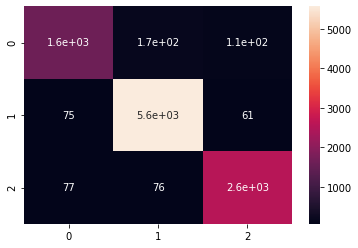

In [48]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

conf = confusion_matrix(test_y_label, predict_y_numpy)
heatmap(conf, annot = True)

# 以下用分類器分全部資料的情緒

In [49]:
"""
這個是用全部去分類 有train test問題
text_dict = {}
for item  in text_at_least_3[0]:
    for text in item:
        
        date = text[0]
        #print(date)
        if not text_dict.get(date):
            text_dict[date] = [text[1]]
        else:
            text_dict[date].append(text[1])
"""



'\n這個是用全部去分類 有train test問題\ntext_dict = {}\nfor item  in text_at_least_3[0]:\n    for text in item:\n        \n        date = text[0]\n        #print(date)\n        if not text_dict.get(date):\n            text_dict[date] = [text[1]]\n        else:\n            text_dict[date].append(text[1])\n'

In [50]:
all_to_be_labeled_date = sorted(set(all_to_be_labeled[0].values))
text_dict ={}
for date in all_to_be_labeled_date:
    cur_data = all_to_be_labeled[all_to_be_labeled[0] == date][1]
    text_dict[date] = np.array(cur_data)

In [51]:
all_to_be_labeled[all_to_be_labeled[0]== key]

NameError: name 'key' is not defined

In [ ]:
text_dict['2020-03-19']

In [ ]:
def get_daily_sentence_emotion(sentences, predict_model):
    encoded_all_x1, encoded_all_x2  = get_encode(sentences)
    predict_y = tuned_model.predict((encoded_all_x1, encoded_all_x2))
    predict_catagories = K.argmax(predict_y, axis=-1)
    predict_catagories = predict_catagories.numpy()
    
    for i in range(len(predict_catagories)):
        if predict_catagories[i] == 2:
            predict_catagories[i] = -1 #invert idx to emotion
    predict_catagories = pd.DataFrame(predict_catagories)

    
    return predict_catagories #return 當天的各自的情緒
    


In [ ]:

daily_pnt = {}
for key in text_dict:
    print(key)
    predicted = get_daily_sentence_emotion(text_dict[key], tuned_model)
    daily_pnt[key] = (text_dict[key],predicted)
with open(f"classed_daily_emotion_categories_len_0.pkl", "wb") as file:
    pickle.dump(daily_pnt, file)
print(daily_pnt)

In [ ]:
with open(f"classed_daily_emotion_categories_len_0.pkl", "wb") as file:
    pickle.dump(daily_pnt, file)

In [ ]:
tuned_model.save("BertClassifierWeights\\saved_model\\20220616.h5")

In [ ]:


def get_different_len_classified_emo_pnt(daily_pnt, length):
    classified_emotion_data = {}
    for key in daily_pnt:
        classified_emotion_data[key] = {-1:0,1:0, 0:0 }
        for idx in range(len(daily_pnt[key][0])):
            cur_sent = daily_pnt[key][0][idx]
            if len(cur_sent)>=length:
                label = daily_pnt[key][1][0][idx]
                classified_emotion_data[key][label] +=1
    classified_emotion_data = pd.DataFrame(classified_emotion_data).T
    classified_emotion_data.columns = ["classified_neg","classified_pos", "classified_neu"]
    classified_emotion_data["classified_pos_ratio"] = classified_emotion_data["classified_pos"]/( classified_emotion_data["classified_pos"]+ classified_emotion_data["classified_neg"])
    classified_emotion_data["classified_neg_ratio"] = classified_emotion_data["classified_neg"]/( classified_emotion_data["classified_pos"]+ classified_emotion_data["classified_neg"])
    return classified_emotion_data


In [ ]:
classified_emotion_list = []
for i in range(3, 7):
    cur_pnt = get_different_len_classified_emo_pnt(daily_pnt, i)
    classified_emotion_list.append(cur_pnt.loc["2020-04-20":, :])

In [ ]:
classified_emotion_list[0]

In [ ]:
with open(f"D:\\論文相關\data\\classifier emotions\\classified_emotion_list_len_0.pkl", "wb") as file:
    pickle.dump(classified_emotion_list, file)

In [ ]:
classified_emotion_len0 = get_different_len_classified_emo_pnt(daily_pnt, 0)
classified_emotion_len0 = classified_emotion_len0.loc["2020-04-20":, :]

In [ ]:
classified_emotion_len0

In [ ]:
classified_emotion_len0.to_pickle(f"D:\\論文相關\data\\classifier emotions\\classed_daily_emotion_categories_len_0_training_data.pkl")

In [ ]:
classified_emotion_len0

In [ ]:
classified_dict_emotion = {}
for key in text_dict:
    print(key)
    predicted = get_daily_sentence_emotion(text_dict[key], tuned_model)
    daily_pnt[key] = (text_dict[key],predicted)
with open(f"classed_daily_emotion_categories_len_0.pkl", "wb") as file:
    pickle.dump(daily_pnt, file)

In [ ]:
from random import sample, randint
sample_key = sample(list(daily_pnt.keys()), 5)

In [ ]:
sample_sentence = []
for date in sample_key:
    cur_dict = daily_pnt[date]
    cur_date = [date]
    
    for i in range(5):
        
        ints = randint(0,len(cur_dict[0]))
        cur_sen = (cur_dict[0][ints], cur_dict[1][0][ints])
        cur_date.append(cur_sen)
    sample_sentence.append(cur_date)

In [ ]:
sample_sentence